# Text classification using Transformers.

<p align="center">
  <a href="https://colab.research.google.com/github/auduvignac/llm-finetuning/blob/main/notebooks/project/draft.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Ouvrir dans Google Colab"/>
  </a>
</p>

## Introduction

L’objectif de ce projet est de réaliser le **fine-tuning d’un Large Language Model (LLM)**, en particulier **DistilBERT**, sur un jeu de données de classification de textes.

DistilBERT est une version compressée et optimisée du modèle BERT, développée par Hugging Face.
Il conserve environ **97 % des performances de BERT** tout en étant **40 % plus léger** et **60 % plus rapide** à l’entraînement et à l’inférence.
Ces caractéristiques en font un modèle particulièrement adapté aux projets pédagogiques et aux cas d’usage nécessitant un compromis entre performance et efficacité computationnelle.

Dans ce projet, nous allons :

* Télécharger et préparer un jeu de données textuel pour la classification de sentiments.
* Adapter le tokenizer et le modèle DistilBERT à ce dataset.
* Entraîner et évaluer le modèle en suivant un pipeline de fine-tuning.
* Analyser les performances obtenues (accuracy, F1-score, matrice de confusion, etc.) et discuter des résultats.

Le projet suit les consignes définies dans le cadre du module *LLM Fine-tuning* : il s’agit d’un travail en binôme, rendu sous la forme d’un **notebook Jupyter** intégrant à la fois le **code, les visualisations et les analyses**.

## Contexte

La classification de texte, et en particulier la **classification de sentiments**, est une tâche classique du traitement automatique du langage naturel (NLP).
Elle consiste à prédire si un texte exprime une opinion **positive** ou **négative**, par exemple dans le cadre de critiques de films, de produits ou de services.

Cette tâche est pertinente car :

* Elle met en jeu des enjeux réels de l’industrie (analyse d’opinions clients, veille sur les réseaux sociaux, modération de contenu, etc.).
* Elle sert souvent de **benchmark** pour comparer des modèles de NLP.
* Elle illustre bien le processus de fine-tuning d’un modèle pré-entraîné sur un corpus généraliste vers une tâche spécifique.

Le modèle choisi pour ce projet, **DistilBERT**, est une version compressée du modèle BERT :

* il réduit le nombre de paramètres et accélère les calculs,
* tout en conservant un haut niveau de performance,
* ce qui le rend adapté à un entraînement sur machine locale avec des ressources limitées (GPU de petite capacité par exemple).

Dans ce projet, nous utiliserons un dataset de type **classification binaire** (par exemple *IMDb Reviews*), permettant de mettre en œuvre un pipeline complet :

* **Préparation des données** (tokenisation, séparation train/validation)
* **Fine-tuning** du modèle DistilBERT
* **Évaluation et analyse des performances**

## Préparation de l’environnement

Dans cette section, l’ensemble des bibliothèques nécessaires au projet est importé. Elles couvrent :

* **Gestion et exploration de données** : `datasets`, `numpy`, `random`, `json`, `math`, `tabulate`
* **PyTorch** : `torch`, `torch.nn`, `torch.optim`, `DataLoader`, etc.
* **Transformers (Hugging Face)** : modèles, tokenizers, configuration, scheduler
* **Évaluation des performances** : métriques de `sklearn`
* **Visualisation** : `matplotlib`, options Jupyter (`%matplotlib inline`, `InlineBackend`)
* **Utilitaires** : `tqdm` pour le suivi des boucles

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import json
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import (
    DatasetDict,
    load_dataset,
)
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
)
from tabulate import tabulate
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    get_linear_schedule_with_warmup,
)

## Préparation du dispositif et reproductibilité

* La reproductibilité est assurée en fixant une **graine aléatoire** (`seed`) : avec la même graine, le mélange des données, l’initialisation des poids et d’autres opérations stochastiques donnent les mêmes résultats d’un exécutable à l’autre.
* Le dispositif de calcul est configuré de manière à utiliser le **GPU** si disponible, ou à défaut le **CPU**.
* L’instruction d’affichage permet de confirmer le dispositif effectivement sélectionné.

In [2]:
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Après la préparation de l’environnement et la mise en place des conditions de reproductibilité, l’étape suivante consiste à définir une **classe `LLMFineTuner`** qui regroupe et automatise l’ensemble du *workflow* de *fine-tuning*.
Cette classe repose sur une composante utilitaire, la **classe `DataCollator`**, qui simplifie la préparation des batchs et contribue à la généralisation du modèle en gérant efficacement la construction des entrées.

## Définition des classes `LLMFineTuner` et `DataCollator`



### Classe `DataCollator`

La classe `DataCollator` est une composante utilitaire qui s'occupe de la préparation des batchs de données.
Elle a pour rôle de :

- gérer la **tokenisation et le padding dynamique** des séquences,
- regrouper les exemples sous forme de batchs compatibles avec PyTorch,
- fournir un format uniforme des entrées pour l'entraînement et l'évaluation du modèle.

Cette classe permet d'isoler la logique de prétraitement des données afin d'alléger l'implémentation du pipeline principal.

In [3]:
class DataCollator:
    """
    Regroupe et organise les exemples en batchs pour le fine-tuning.

    Cette classe :
    - applique un padding dynamique des séquences en fonction du batch,
    - prépare les tenseurs nécessaires (input_ids, attention_mask, labels),
    - retourne un dictionnaire prêt à être passé au modèle Hugging Face.
    """

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, batch, max_length=256, padding="longest", return_tensors="pt"
    ) -> dict[str, torch.Tensor]:
        """
        Prépare un batch de données pour le modèle.

        Applique un padding dynamique via `tokenizer.pad` et retourne
        les tenseurs nécessaires : input_ids, attention_mask et labels.
        """
        return self.tokenizer.pad(
            batch,
            padding=padding,
            max_length=max_length,
            return_tensors=return_tensors,
        )

### Classe `LLMFineTuner`

La classe `LLMFineTuner` implémente l’ensemble du **pipeline de fine-tuning** pour un modèle DistilBERT appliqué à la classification de textes.
Elle centralise toutes les étapes :

* chargement et préparation du dataset,
* initialisation du tokenizer, du modèle et du data collator,
* configuration de l’optimiseur et du scheduler,
* entraînement, validation et évaluation du modèle,
* inférence sur de nouveaux exemples.

Grâce à cette classe, le workflow est rendu **plus modulaire, lisible et réutilisable**, facilitant les expérimentations et la reproductibilité.

## Méthodes de la classe `LLMFineTuner`

| Étape                        | Méthode(s)                                                          | Rôle                                                                            |
| ---------------------------- | ------------------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **1. Initialisation**        | `__init__`                                                          | Initialise les attributs de la classe (dataset, modèle, tokenizer, device, etc.).         |
| **2. Dataset & Tokenizer**   | `set_dataset`<br>`set_tokenizer`                                    | Chargement du dataset et préparation du tokenizer.                                        |
| **3. Pré-processing**        | `split_dataset`<br>`set_data_collator`<br>`set_loaders`             | Prétraitement des données : sous-échantillonnage, tokenisation, création des DataLoaders. |
| **4. Modèle**                | `set_model`                                                         | Chargement du modèle pré-entraîné (DistilBERT).                                           |
| **5. Optimisation**          | `set_optimizer`<br>`set_scheduler`<br>`set_optimizer_and_scheduler` | Configuration de l’optimiseur et du scheduler d’apprentissage.                            |
| **6. Entraînement et Evaluation** | `train_and_validate`<br>`evaluate`<br>`count_parameters`            | Entraînement, validation, évaluation et inspection du modèle.                             |
| **7. Inférence**             | `predict_sentiment`<br>`predict_batch`                              | Prédiction sur un texte unique ou sur un lot de textes.                                   |
| **8. Orchestration**         | `workflow`                                                          | Pipeline complet en mode entraînement, évaluation ou inférence.                           |

In [4]:
class LLMFineTuner:
    """
    Fine-tuning pipeline for DistilBERT sentiment classification.

    Pipeline steps:
    1. Initialisation
        - __init__

    2. Dataset & Tokenizer
        - set_dataset
        - set_tokenizer

    3. Pre-processing
        - split_dataset (needs set_dataset)
        - set_data_collator
        - set_loaders (needs split_dataset, set_data_collator)

    4. Model
        - set_model

    5. Optimization
        - set_optimizer
        - set_scheduler (needs set_optimizer, set_loaders)
        - set_optimizer_and_scheduler

    6. Training & Evaluation
        - train_and_validate
        - evaluate
        - count_parameters

    7. Inference
        - predict_sentiment
        - predict_batch

    8. Workflow Orchestrator
        - workflow
    """

    # =========================
    # 1. INITIALISATION
    # =========================

    def __init__(
        self,
        dataset="scikit-learn/imdb",
        model_cls=DistilBertForSequenceClassification,
        num_labels=2,  # "negative" (0) and "positive" (1)
        pretrained_model_name_or_path="distilbert-base-uncased",
        tokenizer_cls=DistilBertTokenizer,
    ):
        # Données
        self.dataset = dataset
        self.train_set = None
        self.valid_set = None

        # DataLoader
        self.data_collator = None
        self.train_loader = None
        self.valid_loader = None

        # Modèle et tokenisation
        self.tokenizer_cls = tokenizer_cls
        self.model_cls = model_cls
        self.num_labels = num_labels
        self.pretrained_model_name_or_path = pretrained_model_name_or_path

        # Environnement
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

    # =========================
    # 2. DATASET & TOKENIZER
    # =========================
    def set_dataset(self, verbose=False) -> None:
        self.dataset = load_dataset(self.dataset)
        if verbose:
            print(
                f"Dataset loaded :\n"
                f"{self.dataset}\n"
                f"with {len(self.dataset['train'])} examples."
            )

    def set_tokenizer(
        self,
        do_lower_case=True,
        verbose=False,
    ) -> None:
        self.tokenizer = self.tokenizer_cls.from_pretrained(
            self.pretrained_model_name_or_path, do_lower_case=do_lower_case
        )
        if verbose:
            print(
                f"Tokenizer {self.tokenizer_cls.__name__} loaded from "
                f"{self.pretrained_model_name_or_path}"
            )

    # =========================
    # 3. PRE-PROCESSING
    # =========================
    def split_dataset(
        self, max_length=256, n_samples=2000, seed=42, test_size=0.2
    ) -> None:
        """
        Prepares the dataset for training:

        - Shuffles and selects a subset
        - Tokenizes the reviews and generates input_ids and labels
        - Removes unnecessary columns
        - Splits into train/validation sets

        Args:
            n_samples (int): number of examples to select
            test_size (float): proportion of the data to use for validation
            max_length (int): maximum sequence length (truncate if longer)
        """

        def preprocessing_fn(x, tokenizer):
            # Convertit le texte en IDs de tokens
            x["input_ids"] = tokenizer.encode(
                x["review"],
                add_special_tokens=True,
                truncation=True,
                max_length=max_length,
                padding=False,
                return_attention_mask=False,
            )
            # Encode le label
            x["labels"] = 0 if x["sentiment"] == "negative" else 1
            return x

        # Mélanger et sous-échantillonner
        dataset = self.dataset["train"].shuffle(seed).select(range(n_samples))

        # Appliquer le prétraitement
        dataset = dataset.map(
            preprocessing_fn, fn_kwargs={"tokenizer": self.tokenizer}
        )

        # Garder uniquement les colonnes utiles
        dataset = dataset.select_columns(["input_ids", "labels"])

        # Split train / validation
        splitted = dataset.train_test_split(test_size=test_size)

        self.train_set = splitted["train"]
        self.valid_set = splitted["test"]

    def set_data_collator(self) -> None:
        self.data_collator = DataCollator(self.tokenizer)

    def set_loaders(self, train_batch_size=4, eval_batch_size=4) -> None:
        if not self.data_collator:
            raise ValueError("Data collator must be set before data loaders.")
        if not self.train_set or not self.valid_set:
            raise ValueError("Dataset must be split before data loaders.")
        self.train_loader = DataLoader(
            batch_size=train_batch_size,
            collate_fn=self.data_collator,
            dataset=self.train_set,
            shuffle=True,
        )
        self.valid_loader = DataLoader(
            batch_size=eval_batch_size,
            collate_fn=self.data_collator,
            dataset=self.valid_set,
            shuffle=False,
        )
        self.n_valid = len(self.valid_set)
        self.n_train = len(self.train_set)

    # =========================
    # 4. MODELE
    # =========================
    def set_model(
        self,
        verbose=False,
    ) -> None:
        model = self.model_cls.from_pretrained(
            pretrained_model_name_or_path=self.pretrained_model_name_or_path,
            num_labels=self.num_labels,
        )
        self.model = model.to(self.device)
        if verbose:
            print(
                f"Model {self.model_cls.__name__} loaded with "
                f"{self.model.num_labels} labels."
            )

    # =========================
    # 5. OPTIMIZATION
    # =========================
    def set_optimizer(
        self,
        learning_rate=5e-5,
        weight_decay=0.01,
    ) -> None:
        # AdamW is a variant of Adam that includes weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
        )

    def set_scheduler(
        self,
        num_epochs=3,
    ) -> None:
        if not self.optimizer:
            raise ValueError("Optimizer must be set before the scheduler.")
        if not self.train_loader:
            raise ValueError("Data loaders must be set before scheduler.")
        # Total training steps = number of batches * number of epochs
        self.num_total_steps = len(self.train_loader) * num_epochs
        self.num_warmup_steps = int(0.1 * self.num_total_steps)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.num_total_steps,
        )

    def set_optimizer_and_scheduler(
        self,
        learning_rate=5e-5,
        num_epochs=3,
        weight_decay=0.01,
        verbose=False,
    ) -> None:
        self.set_optimizer(learning_rate, weight_decay)
        self.set_scheduler(num_epochs)
        if verbose:
            print(
                f"Optimizer and scheduler set with {self.num_total_steps} "
                f"training steps and {self.num_warmup_steps} warmup steps."
            )

    # =========================
    # 6. TRAINING & EVALUATION
    # =========================
    def train_and_validate(
        self, epochs=3, max_grad_norm=1.0, save_dir="./distilbert-best"
    ) -> None:
        """
        Trains and validates the model for a given number of epochs.

        - Performs forward/backward passes with gradient clipping
        - Updates optimizer and scheduler
        - Evaluates on validation set at the end of each epoch
        - Saves the best model checkpoint based on validation loss

        Args:
            epochs (int): number of epochs to train
            max_grad_norm (float): gradient clipping norm
            save_dir (str): directory to save the best model
        """
        best_val_loss = float("inf")
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")

            # -------- TRAIN --------
            total_train_loss = 0.0
            self.model.train()
            for batch in self.train_loader:
                # move batch tensors to device
                batch = {k: v.to(self.device) for k, v in batch.items()}

                self.optimizer.zero_grad(set_to_none=True)

                # forward pass (returns loss when 'labels' is provided)
                outputs = self.model(**batch)
                loss = outputs.loss
                total_train_loss += loss.item()

                # backward pass
                loss.backward()

                # gradient clipping
                clip_grad_norm_(
                    self.model.parameters(), max_norm=max_grad_norm
                )

                # optimizer + scheduler step
                self.optimizer.step()
                self.scheduler.step()

            avg_train_loss = total_train_loss / len(self.train_loader)
            self.history["train_loss"].append(avg_train_loss)
            print(f"  Training loss: {avg_train_loss:.4f}")

            # -------- VALIDATE --------
            self.model.eval()
            total_val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in self.valid_loader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}

                    outputs = self.model(**batch)
                    loss = outputs.loss
                    logits = outputs.logits

                    total_val_loss += loss.item()

                    preds = logits.argmax(dim=-1)
                    correct += (preds == batch["labels"]).sum().item()
                    total += batch["labels"].size(0)

            avg_val_loss = total_val_loss / len(self.valid_loader)
            val_acc = correct / total if total > 0 else 0.0
            self.history["val_loss"].append(avg_val_loss)
            self.history["val_acc"].append(val_acc)
            print(
                f"  Validation loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}"
            )

            # save best checkpoint
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                self.model.save_pretrained(save_dir)
                self.tokenizer.save_pretrained(save_dir)
                print(f"Saved new best model to {save_dir}")

    def evaluate(self) -> dict[str, object]:
        if not self.valid_loader:
            raise ValueError("Data loaders must be set before evaluation.")
        if not self.model:
            raise ValueError("Model must be set before evaluation.")
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in self.valid_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                logits = outputs.logits
                preds = logits.argmax(dim=-1).cpu().numpy()
                labels = batch["labels"].cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)
        accuracy = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        report = classification_report(
            all_labels, all_preds, target_names=["negative", "positive"]
        )
        return {
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": cm.tolist(),
            "f1_score": f1,
        }

    def count_parameters(self) -> tuple[int, int]:
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(
            p.numel() for p in self.model.parameters() if p.requires_grad
        )
        return total, trainable

    def plot_history(self) -> None:
        """
        Affiche les courbes d'apprentissage (loss et accuracy) enregistrées
        pendant l'entraînement.
        """
        if not hasattr(self, "history") or not self.history:
            raise ValueError(
                "Aucun historique trouvé. Lancez train_and_validate() d'abord."
            )

        epochs = range(1, len(self.history["train_loss"]) + 1)

        plt.figure(figsize=(12, 4))

        # Courbe de loss
        plt.subplot(1, 2, 1)
        plt.plot(
            epochs, self.history["train_loss"], label="Train Loss", marker="o"
        )
        plt.plot(
            epochs,
            self.history["val_loss"],
            label="Validation Loss",
            marker="o",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)

        # Courbe d'accuracy
        plt.subplot(1, 2, 2)
        plt.plot(
            epochs,
            self.history["val_acc"],
            label="Validation Accuracy",
            marker="o",
            color="green",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.grid(True)

        plt.show()

    # =========================
    # 7. INFERENCE
    # =========================
    def predict_sentiment(self, text) -> dict[str, object]:
        # Tokenize the input
        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=256,
            padding="max_length",  # pad single example
            return_tensors="pt",
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

        # Get predicted label
        pred_label = int(logits.argmax(dim=-1).cpu().item())
        label_str = "positive" if pred_label == 1 else "negative"

        return {
            "text": text,
            "pred_label": label_str,
            "probabilities": {
                "negative": float(probs[0]),
                "positive": float(probs[1]),
            },
        }

    def predict_batch(self, texts, max_length=256) -> list[dict[str, object]]:
        """
        Predict sentiment for a batch of texts (list of strings).

        Returns a list of dicts with labels and probabilities.
        """
        # Tokenize the whole batch at once
        inputs = self.tokenizer(
            texts,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding=True,  # pad to longest in batch
            return_tensors="pt",
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        # Decode predictions
        results = []
        for text, prob in zip(texts, probs):
            pred_label = int(prob.argmax())
            label_str = "positive" if pred_label == 1 else "negative"
            results.append(
                {
                    "text": text,
                    "pred_label": label_str,
                    "probabilities": {
                        "negative": float(prob[0]),
                        "positive": float(prob[1]),
                    },
                }
            )
        return results

    # =========================
    # 8. WORKFLOW ORCHESTRATOR
    # =========================
    def workflow(self, mode="train", verbose=False) -> None:
        """
        Run the full workflow depending on mode.

        Args:
            mode (str): "train" (fine-tuning from scratch) or "inference" (load pretrained model)
            model_path (str): path to a saved model if mode="inference"
        """
        if mode == "train":
            print("Starting training workflow...")
            # 1) We load the dataset
            self.set_dataset(verbose=verbose)
            # 2) We load tokenizer + model (for binary classification)
            self.set_tokenizer(verbose=verbose)
            # 3) We prepare the dataset, data collator and data loaders
            self.split_dataset()
            self.set_data_collator()
            self.set_loaders()
            # 4) We prepare the model, optimizer and scheduler
            self.set_model()
            if verbose:
                print(
                    f"Model has {self.count_parameters()[1]} trainable "
                    f"parameters out of {self.count_parameters()[0]} total."
                )
            self.set_optimizer_and_scheduler(verbose=verbose)
            # 5) We train and validate
            self.train_and_validate()
        elif mode == "evaluation":
            if self.pretrained_model_name_or_path is None:
                raise ValueError(
                    "You must provide model_path for evaluation mode."
                )
            print("Starting evaluation workflow...")
            # 1. dataset + tokenizer
            self.set_dataset(verbose=verbose)
            self.set_tokenizer(verbose=verbose)
            # 2. preprocessing + loaders
            self.split_dataset()
            self.set_data_collator()
            self.set_loaders()
            # 3. load model
            self.set_model()
            self.model.eval()
        elif mode == "inference":
            if self.pretrained_model_name_or_path is None:
                raise ValueError(
                    "You must provide model_path for inference mode."
                )
            # 1. We load tokenizer + model
            self.set_tokenizer()
            self.set_model()
            # 2. We set the model to evaluation mode
            self.model.eval()
        else:
            raise ValueError(
                "mode must be 'train', 'evaluation' or 'inference'"
            )

## Initialisation du *fine-tuner*

À ce stade, la classe `LLMFineTuner` peut être instanciée.
L’objet créé, ici nommé `LLMFineTuner_demo`, servira de support pour l’ensemble du pipeline de fine-tuning (chargement des données, entraînement, évaluation et inférence).

In [5]:
LLMFineTuner_demo = LLMFineTuner()

## Téléchargement du jeu de données d'entraînement

La première étape du pipeline consiste à télécharger et charger le **jeu de données** utilisé pour le fine-tuning.
Par défaut, le *dataset* choisi est celui des **critiques de films IMDb**, disponible directement via la librairie `datasets` de Hugging Face.

Ce *dataset* contient :

* des critiques textuelles de films,
* une étiquette associée (`positive` ou `negative`),
* et il est couramment utilisé comme *benchmark* pour la **classification de sentiments**.

In [6]:
LLMFineTuner_demo.set_dataset(verbose=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded :
DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})
with 50000 examples.


## Préparation des entrées du modèle

Le format d’entrée attendu par BERT (et donc par DistilBERT) peut sembler **sur-spécifié**, en particulier lorsqu’on l’applique à une tâche unique comme la classification de séquence, l’étiquetage de mots ou la détection de paraphrases.
Cependant, ce format est conçu pour assurer une compatibilité large avec différentes tâches NLP.

Les principales étapes sont :

* **Ajout de tokens spéciaux** en début et fin de séquence (par ex. `[CLS]`, `[SEP]`),
* **Troncature ou padding** des phrases afin qu’elles aient toutes une **longueur constante**,
* **Construction du masque d’attention** (`attention mask`) pour distinguer les tokens réels du padding.

In [7]:
LLMFineTuner_demo.set_tokenizer(verbose=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer DistilBertTokenizer loaded from distilbert-base-uncased


Avant d’appliquer le prétraitement à l’ensemble du dataset, il est utile de vérifier le bon fonctionnement du *tokenizer* sur une phrase simple.
Prenons par exemple le texte suivant :

```text
"hello my name is kevin"
```

Cet exemple permettra d’illustrer :

* la **découpe en tokens** (WordPiece),
* la **conversion en identifiants numériques (IDs)**,
* l’ajout automatique des **tokens spéciaux** `[CLS]` et `[SEP]`.

In [8]:
message = "hello my name is kevin"

# Étape 1 : tokenisation (WordPiece)
tokens = LLMFineTuner_demo.tokenizer.tokenize(message)
print("Tokens in the sequence:", tokens)

# Étape 2 : encodage (conversion en IDs numériques)
input_ids = LLMFineTuner_demo.tokenizer.encode(
    message, add_special_tokens=True
)

# Étape 3 : tableau alignant IDs et tokens correspondants
table = np.array(
    [
        input_ids,
        [LLMFineTuner_demo.tokenizer.ids_to_tokens[w] for w in input_ids],
    ]
).T

print("Encoded inputs:")
print(tabulate(table, headers=["Token IDs", "Tokens"], tablefmt="fancy_grid"))

Tokens in the sequence: ['hello', 'my', 'name', 'is', 'kevin']
Encoded inputs:
╒═════════════╤══════════╕
│   Token IDs │ Tokens   │
╞═════════════╪══════════╡
│         101 │ [CLS]    │
├─────────────┼──────────┤
│        7592 │ hello    │
├─────────────┼──────────┤
│        2026 │ my       │
├─────────────┼──────────┤
│        2171 │ name     │
├─────────────┼──────────┤
│        2003 │ is       │
├─────────────┼──────────┤
│        4901 │ kevin    │
├─────────────┼──────────┤
│         102 │ [SEP]    │
╘═════════════╧══════════╛


On remarque la présence de tokens spéciaux comme `[CLS]` et `[SEP]` dans la séquence. Ils sont ajoutés automatiquement par HuggingFace.

* **`[CLS]` (classification token)** :
  Ce token est ajouté systématiquement en début de séquence. Dans le cas d’une tâche de classification, la représentation finale associée à `[CLS]` après passage dans les couches du transformeur est utilisée comme **résumé global de la séquence**. Elle sert ensuite de base pour prédire la classe associée au texte.

* **`[SEP]` (separator token)** :
  Ce token est utilisé comme séparateur entre deux segments de texte. Dans une tâche de **classification d’une seule phrase**, sa présence est secondaire. En revanche, il devient essentiel pour des tâches impliquant plusieurs séquences, comme la **détection de paraphrases**, la **classification de paires de phrases**, ou encore les tâches de **Question Answering (Q\&A)** où une question et un contexte doivent être distingués.

Pour conclure quant au tableau obtenu ci-dessus :

* le texte a bien été **découpé en sous-unités lexicales** (*tokens*),
* chaque token est associé à un **identifiant numérique unique**,
* les **tokens spéciaux** `[CLS]` (en début) et `[SEP]` (en fin) ont été ajoutés automatiquement par le tokenizer.

Cela confirme le bon fonctionnement du *tokenizer* et illustre le format attendu des entrées pour le modèle.

## Prétraitement des données

Dans cette étape, les données brutes (texte des critiques et labels de sentiment) sont transformées en un format exploitable par le modèle.

Etant donné que le *padding* n’a pas été effectué dans la fonction de prétraitement, il est réalisé ici.

Ainsi, le code ci-dessous permet de :

1. Récupérer les `input_ids` (qui, pour l’instant, ont des longueurs différentes).
2. Appliquer un **padding dynamique** afin que toutes les séquences aient la même longueur que la plus longue du batch (méthode efficace, qui évite un sur-padding inutile).
3. Ajouter automatiquement un **masque d’attention** (`1` pour les vrais tokens, `0` pour le padding).
4. Convertir le tout en **tenseurs PyTorch** (`torch.LongTensor`), directement exploitables par le modèle.

Le *collator* se charge donc de :

* réaliser le **padding dynamique** du batch,
* ajouter le **masque d’attention** (`0` et `1`),
* retourner les tenseurs dans le format attendu par le modèle.


In [9]:
LLMFineTuner_demo.split_dataset()

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
LLMFineTuner_demo.set_data_collator()

In [11]:
LLMFineTuner_demo.set_loaders()

## Bilan du prétraitement

### Étapes déjà réalisées

| Étape                  | Statut | Code principal                                                      | Objectif                                                  |
| ---------------------- | ------ | ------------------------------------------------------------------- | --------------------------------------------------------- |
| Dataset chargé         | ✅      | `dataset = load_dataset(...)`                                       | Charger les critiques + labels de sentiment               |
| Mélange (shuffle)      | ✅      | `dataset = dataset.shuffle()`                                       | Éviter les biais liés à l’ordre                           |
| Sous-échantillonnage   | ✅      | `dataset.select(range(n_samples))`                                  | Travailler sur 2 000 exemples                             |
| Tokenisation           | ✅      | `dataset.map(preprocessing_fn, fn_kwargs={"tokenizer": tokenizer})` | Texte → tokens, labels → numériques                       |
| Nettoyage des colonnes | ✅      | `select_columns(["input_ids", "labels"])`                           | Garder uniquement les champs utiles                       |
| Split train/valid      | ✅      | `train_test_split(test_size=0.2)`                                   | Créer ensembles d’entraînement et validation              |
| Data collator          | ✅      | `DataCollator(tokenizer)`                                           | Padding dynamique + masque d’attention + tenseurs PyTorch |
| DataLoaders            | ✅      | `DataLoader(train_set, ..., collate_fn=data_collator)`              | Préparer mini-batchs pour le modèle                       |

### Étapes à venir

| Étape                                    | Action attendue                                                                                                    |
| ---------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **Dispositif & reproductibilité**        | Sélectionner GPU si dispo, fixer les graines (`random`, `numpy`, `torch`).                                         |
| **Chargement du modèle**                 | `DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)` puis `.to(device)`. |
| **Optimiseur**                           | Définir `AdamW` (LR typique : `2e-5` à `5e-5`, weight decay : `0.01`).                                             |
| **Scheduler** (optionnel mais conseillé) | Planifier warmup + décroissance avec `get_linear_schedule_with_warmup`.                                            |
| **Boucle d’entraînement**                | Forward pass → calcul loss → backward pass → clipping gradients → step optimizer + scheduler.                      |
| **Boucle de validation**                 | `model.eval()`, calcul des métriques (loss, accuracy, F1).                                                         |
| **Suivi des métriques**                  | Afficher pertes + accuracy (ajouter F1 si classes déséquilibrées).                                                 |
| **Logging / suivi**                      | Affichage par epoch, barre de progression (`tqdm`).                                                                |
| **Checkpointing**                        | Sauvegarder le meilleur modèle + tokenizer : `save_pretrained("./distilbert-best")`.                               |
| **Sanity checks**                        | Vérifier `[CLS]` (id=101), `[SEP]` (id=102), masque d’attention, inspection d’un batch.                            |                                              |

## Chargement du modèle

À ce stade, il est nécessaire de charger le modèle de base et de l’adapter à la tâche de classification :

* **DistilBERT pré-entraîné** est utilisé comme modèle de départ (pré-entraînement sur le *Masked Language Modeling*).
* Une **tête de classification** (couche linéaire) est ajoutée au-dessus de la représentation du token `[CLS]`.
* Le paramètre `num_labels=2` est fixé pour correspondre à une tâche de **classification binaire** (*positive* / *negative*).
* Le modèle est déplacé sur le **dispositif de calcul** défini précédemment (`cuda` si disponible, sinon `cpu`). Il est important que le modèle et les données soient sur le **même device** pour interagir correctement.

In [12]:
LLMFineTuner_demo.set_model(verbose=True)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model DistilBertForSequenceClassification loaded with 2 labels.


* **DistilBERT** est pré-entraîné sur la tâche de *Masked Language Modeling* (prédiction de mots masqués).
* La classe `DistilBertForSequenceClassification` ajoute une **tête de classification** (couche linéaire) initialisée aléatoirement.
* L’encodeur (le cœur de DistilBERT) charge des poids pré-entraînés, mais la tête doit être **apprise à partir de notre dataset de sentiments**.
* Pendant le fine-tuning, la sortie du token spécial `[CLS]` est utilisée comme **représentation globale de la séquence**, à partir de laquelle la tête apprend à prédire *positive* ou *negative*.

Le étapes suivantes du *workflow* sont les suivantes :

1. **Fine-tuning** du modèle sur le dataset IMDb réduit (2 000 exemples).
2. **Utilisation en inférence** pour prédire le sentiment de nouvelles phrases.

## Optimiseur et Scheduler

### Rappel sur l’optimiseur

L’optimiseur est l’algorithme qui met à jour les poids du modèle au cours de l’entraînement, en fonction de la **perte calculée**.
Dans notre cas, nous utilisons **AdamW**, une variante de l’optimiseur Adam qui :

* apprend des taux d’apprentissage différents pour chaque poids,
* applique une **pénalisation (weight decay)** afin de limiter le surapprentissage en empêchant les poids de croître excessivement.

### Rappel sur le *scheduler*

Le *learning rate* (taux d’apprentissage) détermine l’**amplitude des pas** effectués par l’optimiseur à chaque mise à jour des poids.
Le *scheduler* permet de **faire évoluer dynamiquement le learning rate** au cours de l’entraînement.

De manière plus intuitive :

* l'optimiseur détermine la manière dont les poids sont ajustés en fonction de la perte,
* le *scheduler* contrôle l’ampleur des pas d’apprentissage au fil des itérations.

In [13]:
LLMFineTuner_demo.set_optimizer_and_scheduler(verbose=True)

Optimizer and scheduler set with 1200 training steps and 120 warmup steps.


### Configuration de l’optimiseur et du *scheduler* – Résultats

L’optimiseur et le *scheduler* ont été correctement initialisés :

* Nombre total d’étapes d’entraînement : **1200**
* Nombre d’étapes de *warmup* (taux d’apprentissage qui augmente progressivement) : **120**

## Entraînement et Validation

### Forward pass

* Entrée : un batch de critiques, représentées par leurs `input_ids` et `attention_mask`.
* Le modèle :

  * associe chaque token à son embedding,
  * passe les séquences dans l'encodeur DistilBERT (empilement de couches Transformers),
  * récupère l'état caché du token spécial `[CLS]` comme **représentation globale de la phrase**,
  * applique la tête de classification (couche linéaire) sur cette représentation,
  * produit en sortie des **logits** : scores bruts et non normalisés pour chaque classe (*positive* / *negative*).

$$
\text{logits} = W \cdot h_{\text{[CLS]}} + b
$$

### Calcul de la loss

Comparaison des *logits* aux *labels* réels (0 ou 1) via la **fonction de perte d’entropie croisée** :

$$
L = - \Big( y \cdot \log(\hat{y}) + (1-y) \cdot \log(1-\hat{y}) \Big)
$$

où

$$
\hat{y}_i = \frac{e^{\text{logits}_i}}{\sum_j e^{\text{logits}_j}}
$$

### Backward pass

PyTorch calcule automatiquement les gradients de la perte par rapport à chaque paramètre du modèle.

* Le gradient indique comment ajuster un poids pour réduire la perte.
* Exemple : si le gradient est positif, le poids doit être diminué ; s’il est négatif, il doit être augmenté.

### Gradient clipping

Afin d’éviter des gradients trop grands (qui peuvent déstabiliser l’entraînement), application d'un **clipping** :

$$
g = \min(g, \text{valeur}_{\text{seuil}})
$$

### Optimiseur

L’optimiseur applique ensuite les mises à jour des poids en suivant la règle :

$$
w \leftarrow w - \eta \cdot \nabla_w L
$$

où $\eta$ est le **learning rate**.
Ici, nous utilisons **AdamW**, qui ajoute un *weight decay* pour régulariser les poids.

### Scheduler

Le scheduler permet de **moduler le learning rate** au cours du temps :

* augmentation progressive au début (*warmup*),
* décroissance ensuite,
  plutôt qu'un taux d'apprentissage fixe.

### Validation

Après chaque *epoch* :

* désactivation du calcul de gradient (`model.eval()` + `torch.no_grad()`),
* passage des données de validation dans le modèle,
* calcul de la loss et des métriques (accuracy, F1-score).

Cette étape vérifie si le modèle apprend des **règles générales** plutôt que de mémoriser les données d'entraînement.

### Checkpoint

Sauvegarde des poids du modèle lorsque la perte de validation s'améliore.
Cela garantit de conserver la **meilleure version** obtenue durant l'entraînement.


Epoch 1/3
  Training loss: 0.5675
  Validation loss: 0.8055 | Accuracy: 0.8025
Saved new best model to ./distilbert-best

Epoch 2/3
  Training loss: 0.3582
  Validation loss: 0.7440 | Accuracy: 0.8100
Saved new best model to ./distilbert-best

Epoch 3/3
  Training loss: 0.1593
  Validation loss: 0.6324 | Accuracy: 0.8675
Saved new best model to ./distilbert-best


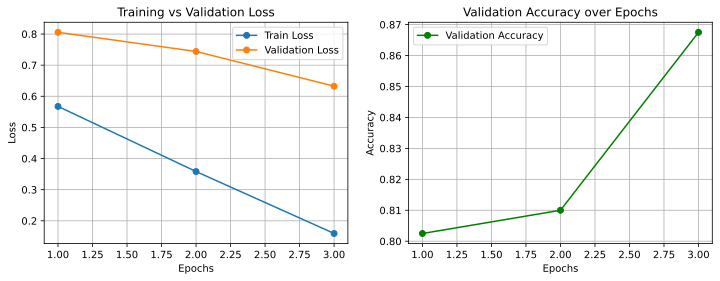

In [14]:
LLMFineTuner_demo.train_and_validate()
LLMFineTuner_demo.plot_history()

### Interprétation

- Le modèle s'améliore progressivement au fil des *epochs* : la perte d'entraînement diminue fortement et la précision (*accuracy*) augmente.

- Une légère divergence entre perte d'entraînement et perte de validation est constatée : le modèle devient plus confiant mais peut être mal calibré ou commencer à sur-apprendre sur certains cas difficiles (*overfitting* léger).

- Grâce au mécanisme de *checkpointing*, le meilleur modèle est sauvegardé à chaque fois que la perte de validation s'améliore. Ici, le modèle sauvegardé à l'*epoch* 3 correspond au meilleur compromis pour la généralisation.

## Sanity Checks

Avant d'analyser les performances ou d'utiliser le modèle en inférence, il est essentiel de vérifier que les données et le prétraitement sont correctement configurés.

L'objectif de cette étape est de s'assurer que le pipeline de préparation des données fonctionne correctement avant de poursuivre avec l'évaluation et l'inférence. Concrètement, nous voulons vérifier que :

- Les dimensions des *batchs* (`input_ids`, `attention_mask`, `labels`) sont cohérentes,
- Les tokens spéciaux [CLS] et [SEP] sont bien présents dans chaque séquence,
- Le padding et la troncature sont appliqués correctement, avec un attention_mask qui distingue bien les vrais tokens des [PAD].

### Sanity Check 1 : Vérification d'un batch

L'objectif est de vérifier que les *batchs* renvoyés par le `DataLoader` ont les bonnes dimensions et contiennent les bons éléments (`input_ids`, `attention_mask`, `labels`).

In [ ]:
# Grab a single batch from the training dataloader
batch = next(iter(LLMFineTuner_demo.train_loader))

# Print shapes
print("Input IDs shape:", batch["input_ids"].shape)
print("Attention mask shape:", batch["attention_mask"].shape)
print("Labels shape:", batch["labels"].shape)

# Print the first example
first_input_ids = batch["input_ids"][0]
first_mask = batch["attention_mask"][0]
first_label = batch["labels"][0]

print("\nFirst input_ids:", first_input_ids.tolist())
print("First attention_mask:", first_mask.tolist())
print("First label:", first_label.item())

# Convert IDs back to tokens to inspect
tokens = LLMFineTuner_demo.tokenizer.convert_ids_to_tokens(first_input_ids)
print("\nDecoded tokens:", tokens)

**Sortie obtenue :**

* `Input IDs shape`: **\[4, 256]** → 4 exemples par batch, séquences de longueur fixe 256.
* `Attention mask shape`: **\[4, 256]** → un masque pour chaque séquence, indiquant les vrais tokens (1) et le padding (0).
* `Labels shape`: **\[4]** → un label par séquence.
* Premier exemple :

  * Les **IDs** sont bien mappés à des tokens lisibles (`this tv show ... [SEP] [PAD] ...`).
  * Le **masque** correspond : 1 pour les tokens réels, 0 pour les `[PAD]`.
  * Le **label** est correctement associé (`0 = negative`).

**Constats :**

* Chaque batch contient 4 échantillons, comme attendu.
* Les séquences sont bien **pad/truncated** à une longueur de 256.
* Le masque d'attention est aligné correctement.
* Les tokens spéciaux `[CLS]` et `[SEP]` sont présents.

### Sanity Check 2 : Présence des tokens spéciaux

L'objectif étant de confirmer que chaque séquence contient bien les *tokens* spéciaux attendus par DistilBERT :

* [CLS] au début (représentation globale de la séquence pour la classification).
* [SEP] à la fin (séparateur de séquences, obligatoire même avec une seule phrase).

In [ ]:
batch = next(iter(LLMFineTuner_demo.train_loader))
iid = batch["input_ids"][0]
assert (
    iid[0].item() == LLMFineTuner_demo.tokenizer.cls_token_id
), "Missing [CLS]"
assert (
    (iid == LLMFineTuner_demo.tokenizer.sep_token_id).any().item()
), "Missing [SEP]"
print("Special tokens OK")

**Constats :**

* [CLS] est bien présent en première position.
* [SEP] est bien présent dans la séquence.

Le modèle recevra donc des entrées valides, conformes au format BERT.

### Sanity Check 3 : Statistiques de padding et troncature

Vérifier la proportion d'exemples *paddés* (séquences plus courtes complétées avec [PAD]) et tronqués (séquences coupées à max_len=256).

In [ ]:
def trunc_pad_stats(dataloader, max_len=256):
    n, n_trunc, n_pad = 0, 0, 0
    for b in dataloader:
        input_ids = b["input_ids"]
        attn = b["attention_mask"]
        # padded examples have any 0 in mask
        n_pad += (attn.sum(dim=1) < input_ids.size(1)).sum().item()
        # truncated examples exactly hit max_len AND have no padding
        n_trunc += ((attn.sum(dim=1) == max_len)).sum().item()
        n += input_ids.size(0)
    return {
        "total_examples": n,
        "padded_frac": n_pad / n,
        "truncated_frac": n_trunc / n,
        "exact_len_frac": (
            n_trunc / n
        ),  # same as truncated_frac with this logic
    }

In [ ]:
stats = trunc_pad_stats(LLMFineTuner_demo.train_loader, max_len=256)
print(json.dumps(stats, indent=4))

**Constats**

* Total d'exemples : 1600 (correspond bien à l'échantillon d'entraînement).
* ~52 % paddés → la moitié des séquences originales étaient plus courtes que 256 tokens.
* ~45 % tronqués → presque la moitié des séquences atteignent la longueur maximale et ont été coupées.

Cela reflète la variabilité naturelle des critiques IMDB : certaines sont très courtes, d'autres très longues.

## Sanity Check 4 : Exemple de séquence paddée

L'objectif est d'fficher un exemple de séquence paddée afin de vérifier :
* que les tokens [PAD] apparaissent bien en fin de séquence,
* que le attention_mask les identifie correctement avec des 0.

In [ ]:
def show_padded_example(dataloader, tokenizer):
    for b in dataloader:
        for i in range(b["input_ids"].size(0)):
            attn = b["attention_mask"][i]
            if attn[-1].item() == 0:  # ends with padding
                ids = b["input_ids"][i]
                toks = tokenizer.convert_ids_to_tokens(ids)
                print("...tokens tail:", toks[-30:])
                print("...mask tail:", attn[-30:].tolist())
                return
    print("No padded example found in this pass")

In [ ]:
show_padded_example(
    LLMFineTuner_demo.train_loader, LLMFineTuner_demo.tokenizer
)

**Constats**

* Les tokens [PAD] sont bien ajoutés en fin de séquence.
* Le attention_mask marque correctement ces positions comme 0 (ignorées par le modèle).
* Cela confirme que le DataCollator gère bien le padding dynamique et que le modèle ne tiendra pas compte des zones vides.

## Récapitulatif des Sanity Checks

| Sanity Check | Vérification                                                   | Résultat                                                      |
| ------------ | -------------------------------------------------------------- | ------------------------------------------------------------- |
| **1**        | Cohérence des batchs (`input_ids`, `attention_mask`, `labels`) | ✅ Dimensions correctes, tokens lisibles, labels présents      |
| **2**        | Présence des tokens spéciaux `[CLS]`, `[SEP]`                  | ✅ Spéciaux correctement insérés                               |
| **3**        | Statistiques de padding et troncature                          | ✅ \~52% paddés, \~45% tronqués (dataset équilibré)            |
| **4**        | Exemple de séquence paddée                                     | ✅ `[PAD]` bien ajoutés en fin, `attention_mask=0` sur padding |

## Inference Helper

Une fois le modèle **fine-tuné**, il peut être utiliser en **inférence** afin de prédire le sentiment de nouveaux textes.

L'idée est simple :

* Entrée : du texte brut (ex. une critique de film).
* Le texte est **tokenizé** puis converti en tenseurs (`input_ids`, `attention_mask`).
* Le modèle produit des **logits** qui sont transformés en probabilités (`softmax`).
* Sortie : un label (`positive` ou `negative`) accompagné des probabilités associées.

Cette étape illustre comment exploiter un modèle entraîné pour réaliser des prédictions concrètes sur des données inédites.

Il est désormais possible de soumettre du texte brut à notre modèle fine-tuné et obtenir une prédiction de sentiment.
La méthode `predict_sentiment` renvoie :
* le texte d'entrée,
* le label prédit (positive ou negative),
* les probabilités associées à chaque classe.


In [ ]:
print(
    json.dumps(
        LLMFineTuner_demo.predict_sentiment(
            "I absolutely loved this movie, it was fantastic!"
        ),
        indent=4,
    )
)
print(
    json.dumps(
        LLMFineTuner_demo.predict_sentiment(
            "This was the worst film I have ever seen."
        ),
        indent=4,
    )
)

Le modèle attribue correctement un sentiment positif à la première phrase et un sentiment négatif à la seconde, avec une très forte confiance.

## Rechargement du modèle sauvegardé

Après l'entraînement, nous avons sauvegardé le meilleur modèle dans `./distilbert-best`.
Nous pouvons maintenant le recharger pour l'utiliser en inférence, sans devoir réexécuter toute la phase de fine-tuning.

Le code ci-dessous se divise de la manière suivante :

* `LLMFineTuner(pretrained_model_name_or_path=model_path)` : on instancie une nouvelle classe en pointant vers le modèle sauvegardé.

* `set_tokenizer()` : recharge le tokenizer utilisé à l'entraînement.

* `set_model()` : recharge la configuration et les poids du modèle.

* `model.eval()` : place le modèle en mode évaluation/inférence (désactive dropout, batchnorm, etc.).

In [ ]:
model_path = "./distilbert-best"
LLMFineTuner_1 = LLMFineTuner(pretrained_model_name_or_path=model_path)
LLMFineTuner_1.set_tokenizer()
LLMFineTuner_1.set_model()
LLMFineTuner_1.model.eval()

Vérifions à présent que le modèle fonctionne correctement.

In [ ]:
print(
    json.dumps(
        LLMFineTuner_1.predict_sentiment(
            "I absolutely loved this movie, it was fantastic!"
        ),
        indent=4,
    )
)
print(
    json.dumps(
        LLMFineTuner_1.predict_sentiment(
            "This was the worst film I have ever seen."
        ),
        indent=4,
    )
)

La première phrase est caractérisée comme positive tandis que la seconde comme négative : **le modèle sauvegardé utilisé en inférence est bien valide**.
Appliquons ce modèle sur plusieurs phrases

In [ ]:
reviews = [
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The acting was decent but the story was too slow.",
    "What a masterpiece - I'd watch it again and again!",
]

batch_results = LLMFineTuner_1.predict_batch(reviews)
for res in batch_results:
    print(json.dumps(res, indent=4))

Les cinq phrases sont correctement catégorisées.

Le tableau ci-dessous résume les étapes opérées jusqu'à présent.

| Step                            | Description                                                                                |
| ------------------------------- | ------------------------------------------------------------------------------------------ |
| **1. Preprocessing & batching** | Préparation du dataset, tokenisation, padding dynamique, DataLoader                        |
| **2. Training & validation**    | Apprentissage du modèle DistilBERT avec suivi des métriques                                |
| **3. Model checkpointing**      | Sauvegarde du **meilleur modèle** basé sur la validation loss                              |
| **4. Inference (single)**       | Utilisation du modèle fine-tuné pour prédire le sentiment d'un texte brut (exemple unique) |
| **5. Inference (batch)**        | Prédiction du sentiment sur plusieurs textes en une seule passe                            |

Après avoir complété le fine-tuning et l'évaluation de `DistilBERT` sur notre tâche de classification de sentiments, nous allons maintenant explorer un autre modèle : `RoBERTa`.

L'objectif est de comparer les performances et le comportement de ces deux architectures, en mettant en évidence :
* les différences de taille et de capacité,
* les variations dans la tokenisation,
* les effets liés au pré-entraînement.

## Choix d'un nouveau modèle : `RoBERTa`

Après avoir travaillé avec `DistilBERT`, nous allons maintenant passer à `RoBERTa` afin de comparer les performances et d'analyser l'impact du choix du modèle.

Le choix s'est porté sur `RoBERTa` pour les raisons suivantes :

* **Plus grand modèle** que DistilBERT, avec davantage de paramètres.
* **Tokenizer différent**, qui repose sur la méthode BPE (Byte-Pair Encoding).
* **Pré-entraînement différent**, basé sur de larges corpus et des stratégies d'entraînement optimisées.

Cette étape permettra de :

1. Recharger le jeu de données et adapter la tokenisation.
2. Entraîner RoBERTa sur le même cas d'usage (sentiment analysis).
3. Comparer ses résultats à ceux obtenus avec DistilBERT.

Exploitons la classe `LLMFineTuner` pour instancier et configurer un nouveau modèle : `RoBERTa-base`.

Pour cela :

* Nous choisissons roberta-base comme modèle de comparaison (mais d'autres modèles comme bert-base-uncased ou MiniLM pourraient aussi être testés).
* Nous rechargeons le même dataset que pour DistilBERT afin de garder une base de comparaison cohérente.
* Nous utilisons l'AutoTokenizer et l'AutoModelForSequenceClassification, car RoBERTa a un tokenizer et une architecture légèrement différents de DistilBERT.


In [ ]:
# 1) We pick the comparison model : roberta-base
# other options that could be tested: "bert-base-uncased",
# "microsoft/MiniLM-L6-H384-uncased"
model_name = "roberta-base"
LLMFineTuner_2 = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path=model_name,
    tokenizer_cls=AutoTokenizer,
)
# 2) We load the dataset
LLMFineTuner_2.set_dataset()
# 3) We load tokenizer + model (for binary classification)
LLMFineTuner_2.set_tokenizer(verbose=True)
LLMFineTuner_2.set_model(verbose=True)

In [ ]:
total_params, trainable_params = LLMFineTuner_2.count_parameters()
print(
    f"[{model_name}] Total params: {total_params/1e6:.1f}M | "
    f"Trainable: {trainable_params/1e6:.1f}M | "
    f"Device: {next(LLMFineTuner_2.model.parameters()).device}"
)

### Comparaison `DistilBERT` et `RoBERTa-base`

| Propriété                                     | `DistilBERT` (base-uncased)                                               | `RoBERTa-base`                                                |
| --------------------------------------------- | --------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Nombre de couches (encodeurs Transformer)** | 6                                                                           | 12                                                              |
| **Taille cachée $d_\text{model}$**         | 768                                                                         | 768                                                             |
| **Têtes d’attention**                         | 12                                                                          | 12                                                              |
| **Dimension par tête**                        | 64                                                                          | 64                                                              |
| **Taille de la couche FFN / intermédiaire**   | 3072                                                                        | 3072                                                            |
| **Nombre de paramètres (approx.)**            | \~66M                                                                       | \~125M                                                          |
| **Longueur maximale des séquences**           | 512                                                                         | 514\* (généralement utilisé comme 512)                          |
| **Embeddings positionnels**                   | Appris (absolus)                                                            | Appris (absolus)                                                |
| **Tokenizer & vocabulaire**                   | WordPiece (30 522 tokens), *minuscules*                                     | BPE au niveau des octets (50 265 tokens), *sensible à la casse* |
| **Embeddings de segment (token type)**        | Non utilisés (le tokenizer peut en générer, mais le modèle les ignore)      | Non utilisés                                                    |
| **Tokens spéciaux**                           | `[CLS]`, `[SEP]`, `[PAD]`, `[MASK]`                                         | `<s>`, `</s>`, `<pad>`, `<mask>`                                |
| **Objectif de pré-entraînement**              | Masked LM + distillation depuis BERT-base (pertes KL + cosinus, pas de NSP) | Masked LM uniquement, **masquage dynamique**, pas de NSP        |
| **Corpora de pré-entraînement (haut niveau)** | Wikipedia + BookCorpus (via BERT enseignant)                                | Plus large : BookCorpus, CC-News, OpenWebText, Stories          |
| **Vitesse d'inférence typique**               | Plus rapide (moitié moins de couches)                                       | Plus lente (architecture plus profonde)                         |
| **Mémoire / VRAM typique**                    | Plus faible                                                                 | Plus élevée                                                     |
| **Compromis pratique**                        | Efficace, avec \~95-97% de la précision de BERT-base                        | Précision brute plus forte, mais coût computationnel plus élevé |

### Points clefs à retenir

* **Capacité** : `RoBERTa-base` possède environ **2x plus de couches** et **2x plus de paramètres** que `DistilBERT` : en théorie, un plafond de performance plus élevé.
* **Efficacité** : `DistilBERT` est bien plus **léger et rapide**, idéal lorsque la latence ou la mémoire (VRAM) sont critiques.
* **Tokenisation** : WordPiece (*sans casse*) vs BPE au niveau des octets (*sensible à la casse*) : impact potentiel sur le traitement des tokens rares ou Unicode.
* **Objectifs d'entraînement** : `DistilBERT` bénéficie de la **distillation** depuis BERT-base, tandis que `RoBERTa` mise sur un **MLM plus robuste** (masquage dynamique) et un **corpus d'entraînement plus large**.

**Elements de précision sur le masquage dynamique** :

Le **masquage dynamique** (*dynamic masking*) est une différence importante entre BERT/DistilBERT et RoBERTa.

* **BERT / DistilBERT** : utilisent du **masquage statique** :
  Lors de la création du dataset de pré-entraînement, les *tokens* qui devront être remplacés par `[MASK]` sont choisis à l'avance. Chaque fois qu'une phrase est réutilisée à l'entraînement, ce sont toujours les mêmes positions qui sont masquées.

* **RoBERTa** : utilise du **masquage dynamique** :
  À chaque passage d'un même texte pendant l'entraînement, les tokens masqués sont choisis **aléatoirement à nouveau**. Ainsi, un même texte peut fournir plusieurs exemples de masquage différents.

**Conséquence** :

* RoBERTa « voit » beaucoup plus de combinaisons et apprend des représentations plus robustes.
* Cela augmente l'efficacité de l'entraînement et améliore la généralisation.



## Reconstruction du dataset & des DataLoaders pour le nouveau modèle

Comme nous utilisons désormais le tokenizer de `RoBERTa`, il est nécessaire de :
* Re-tokeniser le dataset avec ce nouveau tokenizer,
* Recréer le `DataCollator` (pour gérer le *padding* dynamique et l'*attention mask*),
* Reconstruire les DataLoaders pour l'entraînement et la validation.

Cette étape garantit que les deux modèles (`DistilBERT` et `RoBERTa`) soient comparés dans des conditions identiques.

In [ ]:
LLMFineTuner_2.split_dataset()

### Points à noter

* **Différences de tokenisation** : RoBERTa utilise la **BPE au niveau des octets** et des tokens spéciaux différents (`<s>`, `</s>`, `<pad>`, `<mask>`).
* **ID de padding** : pour RoBERTa, l'ID associé à `<pad>` est généralement **1** (alors qu'il est **0** pour DistilBERT/BERT). L'utilisation de `tokenizer.pad` permet d'éviter de coder cet ID en dur et prévient des erreurs dans les masques d'attention.
* **Longueur maximale** : il est important de conserver la même valeur de `MAX_LEN` (ici **256**) que dans l'expérience DistilBERT afin de garantir une **comparaison équitable**. Sinon, on mélangerait l'effet de la **capacité du modèle** avec celui de la **longueur de contexte**.

Après avoir reconstruit le dataset tokenisé pour RoBERTa, nous devons :
* Initialiser un nouveau DataCollator compatible avec son tokenizer,
* Créer les DataLoaders pour l'entraînement et la validation.

In [ ]:
LLMFineTuner_2.set_data_collator()
LLMFineTuner_2.set_loaders()

In [ ]:
print(
    f"Pad token ID: {LLMFineTuner_2.tokenizer.pad_token_id}\n"
    f"Special tokens:\n {json.dumps(LLMFineTuner_2.tokenizer.special_tokens_map, indent=2)}\n"
    f"Train, valid sizes: {LLMFineTuner_2.n_train}, {LLMFineTuner_2.n_valid}"
)

### Observations

* **ID du padding** : `1` (RoBERTa) au lieu de `0` (DistilBERT/BERT).
* **Tokens spéciaux** (propres à RoBERTa) :

  * `<s>` = `[CLS]`
  * `</s>` = `[SEP]`
  * `<pad>` = `[PAD]`
  * `<mask>` = `[MASK]`
* **Répartition des données** :

  * Entraînement : **1600 exemples**
  * Validation : **400 exemples**

Après avoir préparé le *dataset* et les *DataLoaders*, la prochaine étape consiste à :
* Définir l'optimiseur (AdamW), qui ajustera les poids du modèle en fonction de la perte.
* Mettre en place le *scheduler*, qui modulera le taux d'apprentissage au cours de l'entraînement (phase de *warmup* suivie d'une décroissance).

Cette étape assure une stabilisation de l'entraînement et permet à `RoBERTa` d'apprendre efficacement sans sur-ajuster trop vite.

In [ ]:
LLMFineTuner_2.set_optimizer()
LLMFineTuner_2.set_scheduler()

In [ ]:
print(
    f"[{model_name}] steps={LLMFineTuner_2.num_total_steps}, warmup={LLMFineTuner_2.num_warmup_steps}"
)

### Points à retenir

* Pour comparer correctement les deux modèles, il est important de **conserver les mêmes hyperparamètres** (learning rate, weight decay, nombre d'époques).
* Si `RoBERTa` obtenait de moins bons résultats avec `2e-5`, il pourrait être pertinent d'essayer un **taux d'apprentissage plus petit** (`1e-5`), car les modèles plus grands ont souvent besoin de pas plus fins pour converger correctement.

## Éléments théoriques

Avant de lancer l'entraînement de **RoBERTa**, rappelons rapidement les notions clés impliquées :

### Forward pass

* La séquence d'entrée est **tokenisée** puis passée dans l'encodeur Transformer.
* Le vecteur associé au token spécial (`[CLS]` pour BERT / `<s>` pour RoBERTa) est utilisé comme **représentation globale**.
* Une **tête de classification** (couche linéaire) produit les logits :

$$
z = W h_{\text{CLS}} + b
$$

### Softmax : Probabilités

Les logits sont transformés en probabilités pour chaque classe (binaire ici) :

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}, \quad C=2
$$

### Fonction de perte

Avec l'entropie croisée :

$$
L = - \Big( y \cdot \log(\hat{y}_1) + (1-y) \cdot \log(\hat{y}_0) \Big)
$$

### Backpropagation

Les gradients des poids sont calculés via la règle de la chaîne :

$$
\nabla_w L = \frac{\partial L}{\partial w}
$$

### Gradient clipping

Pour stabiliser l'apprentissage, les gradients trop grands sont réduits :

$$
g \leftarrow \frac{g}{\max(1, \tfrac{\|g\|}{\tau})}
$$

### Optimisation (AdamW)

L'optimiseur maintient des moyennes mobiles des gradients :

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

Après correction de biais :

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

Mise à jour des poids avec décroissance :

$$
w_t = w_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \eta \cdot \lambda w_{t-1}
$$

### Scheduler (Warmup + Decay)

Le taux d'apprentissage évolue en deux phases :

$$
\text{lr}(t) =
\begin{cases}
  \eta \cdot \frac{t}{T_\text{warmup}} & \text{si } t < T_\text{warmup} \\\\
  \eta \cdot \left(1 - \frac{t - T_\text{warmup}}{T_\text{total} - T_\text{warmup}}\right) & \text{si } t \geq T_\text{warmup}
\end{cases}
$$

Cette combinaison (AdamW + Scheduler) est devenue **le standard de facto** pour entraîner efficacement les modèles Transformers.

Abordons à présent la phase de validation et d'entraînement de sorte à sélectionner le meilleur modèle et le confronter à `DistilBert`.

## Validate and train

In [ ]:
LLMFineTuner_2.train_and_validate(save_dir="./roberta-best")
LLMFineTuner_2.plot_history()

Au vu des résultats ci-dessus, `RoBERTa` semble apprendre plus lentement au début mais finit par dépasser `DistilBERT` en performance (90,5% vs ~86,7%).

Dans la continuité de cette comparaison, utilisons à présent des métriques d'évalution telles que l'*accuracy*, le f1-score et la metrice de confusion.

## Métriques d'évaluation (Accuracy, F1, Matrice de confusion)

In [ ]:
model_distilBert = LLMFineTuner(
    pretrained_model_name_or_path="./distilbert-best"
)
model_distilBert.workflow(mode="evaluation")
metrics_model_distilBert = model_distilBert.evaluate()
print(f"Accuracy: {metrics_model_distilBert['accuracy']:.4f}")
print(f"F1-score: {metrics_model_distilBert['f1_score']:.4f}\n")

print("Confusion Matrix:")
for row in metrics_model_distilBert["confusion_matrix"]:
    print(row)

print("\nClassification Report:")
print(metrics_model_distilBert["classification_report"])

In [ ]:
model_roberta = LLMFineTuner(
    model_cls=AutoModelForSequenceClassification,
    pretrained_model_name_or_path="./roberta-best",
    tokenizer_cls=AutoTokenizer,
)
model_roberta.workflow(mode="evaluation")
metrics_model_roberta = model_roberta.evaluate()
print(f"Accuracy: {metrics_model_roberta['accuracy']:.4f}")
print(f"F1-score: {metrics_model_roberta['f1_score']:.4f}\n")

print("Confusion Matrix:")
for row in metrics_model_roberta["confusion_matrix"]:
    print(row)

print("\nClassification Report:")
print(metrics_model_roberta["classification_report"])

### Comparaison DistilBERT vs RoBERTa (après *fine-tuning*)

| Modèle         | Accuracy   | F1-score   | Matrice de confusion      | Remarques principales                                                                                |
| -------------- | ---------- | ---------- | ------------------------- | ---------------------------------------------------------------------------------------------------- |
| **DistilBERT** | **0.9625** | **0.9616** | \[\[197, 9], \[6, 188]]   | Très bonnes performances globales, léger déséquilibre mais excellente précision/rappel.              |
| **RoBERTa**    | 0.9400     | 0.9409     | \[\[185, 10], \[14, 191]] | Un peu moins performant que DistilBERT ici, erreurs un peu plus fréquentes sur la classe *positive*. |

## Conclusion

* Dans cette expérience, **DistilBERT surpasse RoBERTa** à la fois en **accuracy** et en **F1-score**.
* Cela peut sembler contre-intuitif (RoBERTa étant plus gros et plus puissant), mais :

  * DistilBERT a peut-être mieux convergé avec seulement 3 epochs.
  * Le **learning rate** ou d’autres hyperparamètres pourraient être mieux adaptés à DistilBERT qu’à RoBERTa.
  * Avec un tuning plus fin (LR plus bas pour RoBERTa, plus d’époques), RoBERTa pourrait rattraper voire dépasser DistilBERT.